# GW230529 rates and manification analysis

## Model 1 (Uniform distribution of masses)

here is the complete settings for the simulation. This model is less astrophysical.

**Source related:**

* source frame mass: m1 and m2 sample from uniform distribution (m1>m2) lim[1,3]Mo. (source: bilby uniform)
* Geocent time period: uniform prior, 1 year GPS: {'min_': 1238166018, 'max_': 1269702018} (source: bilby uniform)
* Redshift: zs sample from normalized merger rate density, lim[0,5], (source: [merger rate density distribution](https://ler.readthedocs.io/en/latest/GW_events.html#Merger-Rate-Density-Formula))
* ra:  sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}, (source: bilby uniform)
* dec:  sampler_cosine [-np.pi/2, np.pi/2], (source: bilby cosine)
* phase : sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}, (source: bilby uniform)
* psi: sampler_uniform {'min_': 0.0, 'max_': 3.141592653589793}, (source: bilby uniform)
* theta_jn:   sampler_sine  [0, np.pi], (source: bilby sine)

**Lens related**

* Optical depth: SIE, (source: Haris et al 2018, and Fei Xu et al 2022)
  * so zs for lensed are rejection sampled with optical depth.
* Lens redshifts: SDSS catalogue (0 to zs), the function of zs Reenske et al. 2021 ( eqnC13). [`ler` function](https://github.com/hemantaph/ler/blob/bce3330638a13ee0883d19633abb17b98791c901/ler/lens_galaxy_population/jit_functions.py#L218)
* Velocity dispersion: gengamma, Haris et al 2018, a=2.32 / 2.67, c=2.67, vd_min=10., vd_max=360.(https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gengamma.html) use in Haris et al upto zs~1.5 (with a=2.32 / 2.67, c=2.67)
  * Note that there is a hard cut at vd_max=350., which is based of SDSS galaxy catalogue, Collet et al. 2015.
* Axis ratio: Raleigh (with Velocity dispersion dependence) {'q_min': 0.2, 'q_max': 1.0}, (source: Haris et al 2018)
* axis_rotation_angle : uniform {'phi_min': 0.0, 'phi_max': 6.283185307179586}, (source: Haris et al 2018)
* shear: normal {'scale': 0.05}, (source: Haris et al 2018)
* mass_density_spectral_index: normal {'mean': 2.0, 'std': 0.2}, (source: Haris et al 2018)

**Image related:**

* Strong lensing condition: num_images>=2
* Lens equation solver: EPL+Shear, `lenstronomy`
* Source position: sample within caustic,  Ewoud et. al. 2022

**SNR related:**

* Waveform_approximant: IMRPhenomD
* No spin
* SNR threshold: 8 (for lensed, only one image detectable, not two)
* PSD: 'L1' (attached) 
  * this was used in PE, as suggested by Justin
  * generated with bayeswave, considering data near the event. 
* f_min: 20Hz
* sampling frequency: 2048Hz
* delta_f: 1/duration, and the duration is dynamic, its dependent on the masses, check `gwsnr`'s [chirptime](https://github.com/hemantaph/gwsnr/blob/1de37b036204cc2da35041bdb608ad368684c58e/gwsnr/njit_functions.py#L14)

In [ ]:
# # This code was used to generate the data

# from ler.rates import LeR

# ler = LeR(npool=8,
#           verbose=False, 
#           event_type='BNS', 
#           mtot_max=51,  # for SNR interpolation
#           z_max=5,
#           psds={'L1':'custom_psd.txt'},
#           snr_type="interpolation",
#           source_priors=dict(source_frame_masses='binary_masses_uniform',),
#           source_priors_params=dict(
#               source_frame_masses=dict(
#                   m_min=1,
#                   m_max=3,
#               ),
#           lens_priors=dict(
#             velocity_dispersion="velocity_dispersion_gengamma",
#             ),
#           lens_priors_params=dict(
#             velocity_dispersion=dict(a=2.32 / 2.67, c=2.67, vd_min=10, vd_max=350),
#             ),
#           ),
#           )

# # snr_cut=8.0
# # time will take long time sample
# ler.selecting_n_lensed_detectable_events(size=1000, batch_size=200000,snr_threshold=8.0, num_img=1,output_jsonfile='n_lensed_detectable_bns_uniformL1_new.json', meta_data_file='n_lensed_detectable_bns_uniformL1_new_meta.json', resume=True);

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# call the LeR class
from ler.rates import LeR
from ler.utils import get_param_from_json
from scipy.stats import gaussian_kde

### Lensed events

In [19]:
# get data
lensed_params_detectable = get_param_from_json("n_lensed_detectable_bns_uniformL1_new.json")
lensed_params_detectable_meta = get_param_from_json("n_lensed_detectable_bns_uniformL1_new_meta.json")

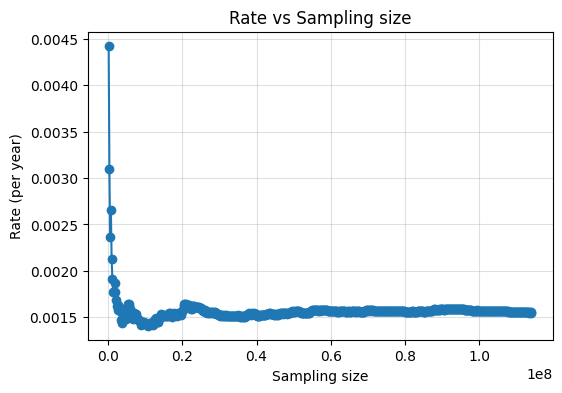

In [20]:
# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(lensed_params_detectable_meta['events_total'], lensed_params_detectable_meta['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [21]:
# take average from 0.6e8
# select only events after sampling size of 
idx = np.where(lensed_params_detectable_meta['events_total'] > 0.6e8)[0]
# take average 
rate_lensed = np.mean(lensed_params_detectable_meta['total_rate'][idx])
print('Rate (per year) =', rate_lensed)

Rate (per year) = 0.0015685833467114438


In [23]:
# getting magnification and snr
snr_l = lensed_params_detectable['optimal_snr_net'].flatten()
mu = lensed_params_detectable['magnifications'].flatten()
mu_mod1_l = abs(mu[np.where(snr_l>8)[0]]) # model 1 lensed
np.shape(mu_mod1_l)

(1763,)

### Un-lensed

In [6]:
# # This code was used to generate the data

# from ler.rates import LeR

# ler = LeR(npool=8,
#           verbose=False, 
#           event_type='BNS', 
#           mtot_max=51,  # for SNR interpolation
#           z_max=5,
#           psds={'L1':'custom_psd.txt'},
#           snr_type="interpolation",
#           source_priors=dict(source_frame_masses='binary_masses_uniform',),
#           source_priors_params=dict(
#               source_frame_masses=dict(
#                   m_min=1,
#                   m_max=3,
#               ),
#           lens_priors=dict(
#             velocity_dispersion="velocity_dispersion_gengamma",
#             ),
#           lens_priors_params=dict(
#             velocity_dispersion=dict(a=2.32 / 2.67, c=2.67, vd_min=10, vd_max=350),
#             ),
#           ),
#           )

# # snr_cut=8.0
# ler.selecting_n_unlensed_detectable_events(size=1000, batch_size=200000,snr_threshold=8.0, output_jsonfile='n_unlensed_detectable_bns_uniformL1_new.json', meta_data_file='n_unlensed_detectable_bns_uniformL1_new_meta.json', resume=False);

In [28]:
lensed_params_detectable = get_param_from_json("n_unlensed_detectable_bns_uniformL1_new.json")
meta_data = get_param_from_json("n_unlensed_detectable_bns_uniformL1_new_meta.json")

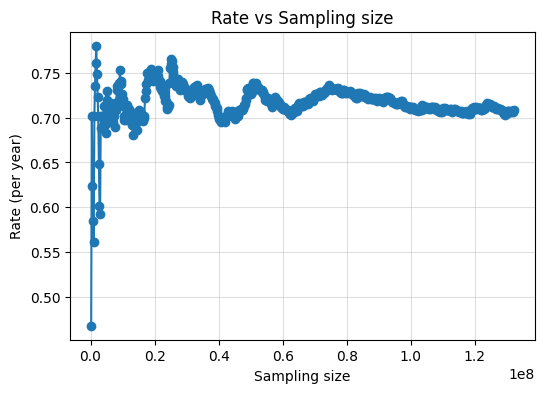

In [29]:
# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [30]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 1e8)[0]
# take average 
rate_unlensed = np.mean(meta_data['total_rate'][idx])
print('Rate (per year) =', rate_unlensed)

Rate (per year) = 0.7090594893323381


## Model 2 (Astrophysical distribution of masses of binary pulsars, double gaussian)

here is the complete settings for the simulation. This model is less astrophysical.

**Source related:**

* source frame mass: double Gaussian distribution, lim[1,2.3]Mo. (source: Alsing et al. 2018 and M. Farr et al. 2020.)
* Geocent time period: uniform prior, 1 year GPS: {'min_': 1238166018, 'max_': 1269702018} (source: bilby uniform)
* Redshift: zs sample from normalized merger rate density, lim[0,5], (source: [merger rate density distribution](https://ler.readthedocs.io/en/latest/GW_events.html#Merger-Rate-Density-Formula))
* ra:  sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}, (source: bilby uniform)
* dec:  sampler_cosine [-np.pi/2, np.pi/2], (source: bilby cosine)
* phase : sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}, (source: bilby uniform)
* psi: sampler_uniform {'min_': 0.0, 'max_': 3.141592653589793}, (source: bilby uniform)
* theta_jn:   sampler_sine  [0, np.pi], (source: bilby sine)

**Lens related**

* Optical depth: SIE, (source: Haris et al 2018, and Fei Xu et al 2022)
  * so zs for lensed are rejection sampled with optical depth.
* Lens redshifts: SDSS catalogue (0 to zs), the function of zs Reenske et al. 2021 ( eqnC13). [`ler` function](https://github.com/hemantaph/ler/blob/bce3330638a13ee0883d19633abb17b98791c901/ler/lens_galaxy_population/jit_functions.py#L218)
* Velocity dispersion: redshift dependent velocity dispersion, lim[0,600]km/s,[Wempe et al. 2022](https://arxiv.org/pdf/2204.08732.pdf)
  * No hard cut at vd_max=350.
* Axis ratio: Raleigh (with Velocity dispersion dependence) {'q_min': 0.2, 'q_max': 1.0}, (source: Haris et al 2018)
* axis_rotation_angle : uniform {'phi_min': 0.0, 'phi_max': 6.283185307179586}, (source: Haris et al 2018)
* shear: normal {'scale': 0.05}, (source: Haris et al 2018)
* mass_density_spectral_index: normal {'mean': 2.0, 'std': 0.2}, (source: Haris et al 2018)

**Image related:**

* Strong lensing condition: num_images>=2
* Lens equation solver: EPL+Shear, `lenstronomy`
* Source position: sample within caustic,  Ewoud et. al. 2022

**SNR related:**

* Waveform_approximant: IMRPhenomD
* No spin
* SNR threshold: 8 (for lensed, only one image detectable, not two)
* PSD: 'L1' (attached) 
  * this was used in PE, as suggested by Justin
  * generated with bayeswave, considering data near the event. 
* f_min: 20Hz
* sampling frequency: 2048Hz
* delta_f: 1/duration, and the duration is dynamic, its dependent on the masses, check `gwsnr`'s [chirptime](https://github.com/hemantaph/gwsnr/blob/1de37b036204cc2da35041bdb608ad368684c58e/gwsnr/njit_functions.py#L14)

In [12]:
# from ler.rates import LeR

# ler = LeR(npool=8,
#           verbose=False, 
#           event_type='BNS', 
#           mtot_max=51, 
#           z_max=5,
#           psds={'L1':'custom_psd.txt'},
#           snr_type="interpolation",
#           )
          
# # snr_cut=8.0
# # time will take long time sample
# ler.selecting_n_lensed_detectable_events(size=1000, batch_size=200000,snr_threshold=8.0, num_img=1, output_jsonfile='n_lensed_detectable_bns.json', meta_data_file='n_lensed_detectable_bns_meta.json', resume=True);

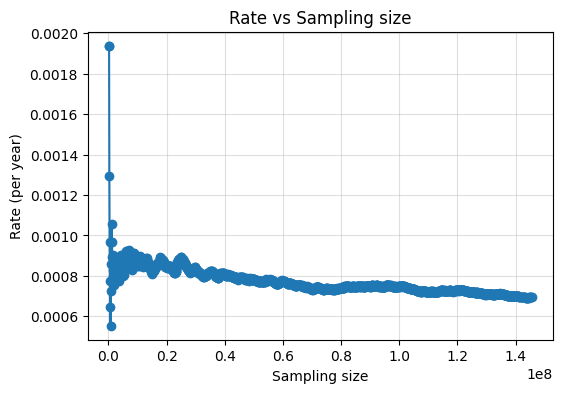

In [34]:
lensed_params_detectable = get_param_from_json('n_lensed_detectable_bns.json')
meta_data = get_param_from_json('n_lensed_detectable_bns_meta.json')

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [35]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 0.8e8)[0]
# take average 
rate_lensed = np.mean(meta_data['total_rate'][idx])
print('Rate (per year) =', rate_lensed)

Rate (per year) = 0.0007287450818946372


In [36]:
# getting magnification and snr
snr_l = lensed_params_detectable['optimal_snr_net'].flatten()
mu = lensed_params_detectable['magnifications'].flatten()
mu_mod2_l = abs(mu[np.where(snr_l>8)[0]]) # model 1 lensed

In [37]:
np.shape(mu_mod1_l), np.shape(mu_mod2_l)

((1763,), (907,))

### Un-lensed

In [38]:
# # snr_cut=8.0
# ler.selecting_n_unlensed_detectable_events(size=500, batch_size=100000,snr_threshold=8.0, output_jsonfile='n_unlensed_detectable_bns.json', meta_data_file='n_unlensed_detectable_bns_meta.json', resume=True);

In [39]:
# let's see how rate varies with sampling size
unlensed_params_detectable = get_param_from_json("n_unlensed_detectable_bns.json")
meta_data = get_param_from_json('n_unlensed_detectable_bns_meta.json')
meta_data.keys()

dict_keys(['events_total', 'detectable_events', 'total_rate'])

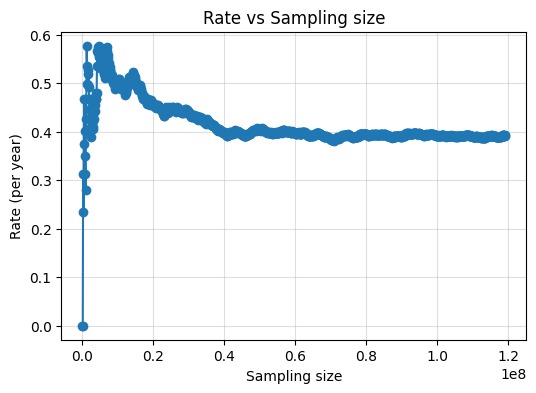

In [40]:
# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [41]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 0.6e8)[0]
# take average 
rate_unlensed = np.mean(meta_data['total_rate'][idx])
print('Rate (per year) =', rate_unlensed)

Rate (per year) = 0.3922295568621635


## Magnification comparison

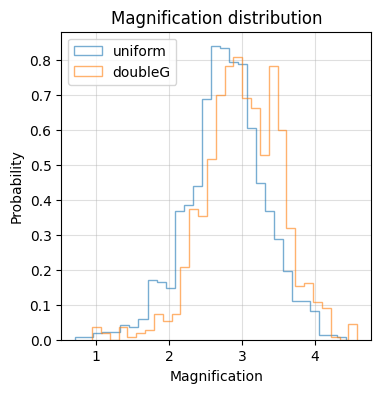

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.hist(np.log10(mu_mod1_l), bins=30, alpha=0.6, density=True, label='uniform', histtype='step')
plt.hist(np.log10(mu_mod2_l), bins=30, alpha=0.6, density=True, label='doubleG', histtype='step')
plt.xlabel('Magnification')
plt.ylabel('Probability')
plt.title(r'Magnification distribution')
plt.grid(alpha=0.4)
plt.legend()
plt.show()

## Rate comparison

* table of rates 
*  Model 1: Uniform distribution of masses
*  Model 2: Astrophysical distribution of masses of binary pulsars, double gaussian

| Model | Un-Lensed | Lensed | Un-lensed/lensed |
|-------|-----------|--------|------------------| 
| 1     | 0.7091    | 0.0015 | 472.73           |
| 2     | 0.3922    | 0.0007 | 560.28           |